# GLM run time benchmarks

Benchmarks for the GeneralizedLinearRegressor added in [scikit-learn#9405](https://github.com/scikit-learn/scikit-learn/pull/9405).

The below results are obtained on an Intel(R) Xeon(R) CPU E3-1270 v6 @ 3.80GHz  (4 CPU cores)

## Conclusions

We start by presenting conclusions. For more details and figures, see benchmarks below.

### Dense data

**Solver comparison**

Comparing different solvers for `family="normal"`
 - in the case `n_features << n_samples`, `solver="irls"` appears to be the fastest overall for `n_features < 20`. For larger number of features, `"lbfgs"` is preferable.
 - in the case `n_features > n_samples` both `cd` and `irls` behave poorly. In general `cd` is slowest particularly when the number of features is large. 

Empirically, I didn't see significant difference in the runtime between `family="normal", link="identity"` and `family="poisson", link="poisson"` (or `family="binomial", link="logit"`), so some of these and following conclusions can probably be generalized.


**Comparing with existing scikit-learn models with `family="normal"`**

This are preliminary results, and all parameters need to be double-checked again that
tolerances and the number or iterators are identical. The equivalence on the obtained solution is checked in test, but again it may need more checks.

 - `Ridge` and `GeneralLinearRegressor` don't have identical solvers, but FWIW using the "cholesky" and "lbfgs" respectively, overall `Ridge` is 2-3x faster.
 - Interestingly this implementation with `cd` solver and `l1_ratio=0.5` appears to be faster than `ElasticNet` by 2-3x. Again more checks are needed to make sure that the comparison is valid.
 - GLS with `family="binomial", loss="logit"` 1-1.3x slower than LogisticRegression when both use `solver="lbfgs"`. Interestingly, with `solver="irls"` this implementation can be faster if
 `n_features` is small.

### Sparse data

Here, the results are less competitive. I think some of the intermediary
arrays must be cast t dense, even with relatively small datasets (subset of
RCV1: ~40k features, a few 10k-100k samples). I have run into memory error
with all solvers (on a 32GB RAM machine), and by reducing the data size the
computations are still relatively slow. It might be preferable to say that
some solvers don't support sparse arrays, rather than yielding memory errors.

In [1]:
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import GeneralizedLinearRegressor
from sklearn.datasets import make_regression, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_rcv1

from neurtu import delayed, timeit, Benchmark

## 1. Solver comparison

In this benchmark we use synthetic data created with [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html)

In [2]:
def make_solver_benchmark(
    n_features=50,
    ax=None,
    n_samples_range=np.linspace(1000, 100_000, 5, dtype=np.int),
    task="regression",
    repeat=1,
    sparse=False,
    metric_name="wall_time",
    **kwargs,
):
    """Benchmark different solvers of GeneralizedLinearRegressor"""

    dataset_kwargs = dict(
        n_samples=n_samples_range.max(),
        n_features=n_features,
        n_informative=n_features // 5,
    )
    if task == "regression":
        if sparse:
            rcv1 = fetch_rcv1()
            _, y = make_regression(n_samples=n_samples_range.max(), random_state=42)
            if (
                rcv1.data.shape[0] < n_samples_range.max()
                or rcv1.data.shape[1] < n_features
            ):
                raise ValueError
            X = rcv1.data
        else:
            if sparse:
                raise NotImplementedError
            X, y = make_regression(
                effective_rank=n_features // 5, tail_strength=0.6, **dataset_kwargs
            )

        y += abs(y.min())
    elif task == "classification":
        X, y = make_classification(n_classes=2, **dataset_kwargs)
    else:
        raise ValueError
    if not sparse:
        X = StandardScaler().fit_transform(X)

    # make sure the target is positive

    if n_samples_range.max() > 10000:
        n_samples_scale = 1000
    else:
        n_samples_scale = 1

    bench = []

    if not sparse:
        solver_list = ["irls", "lbfgs", "newton-cg", "cd"]
    else:
        solver_list = ["lbfgs", "newton-cg", "cd"]
    for n_samples in n_samples_range:
        for solver in solver_list:
            model = GeneralizedLinearRegressor(solver=solver, **kwargs)
            bench.append(
                delayed(
                    model,
                    tags={"n_samples": n_samples / n_samples_scale, "solver": solver},
                ).fit(X[:n_samples, :n_features], y[:n_samples])
            )
    res = Benchmark(repeat=repeat, **{metric_name: True})(bench)
    if repeat > 1:
        res = res.loc[:, (metric_name, "mean")].unstack(-1)
    else:
        res = res.loc[:, metric_name].unstack(-1)
    ax = res.plot(marker="o", ax=ax)
    ax.set(
        title=f"n_features={n_features}",
        xlim=(0, n_samples_range.max() / n_samples_scale),
    )
    if metric_name == "wall_time":
        ax.set(ylabel="wall time (s)")
    elif metric_name == "peak_memory":
        ax.set(ylabel="peak memory (MB)")
    if n_samples_scale > 1:
        ax.set(xlabel="n_samples (10³)")
    else:
        ax.set(xlabel="n_samples")

### 1.1. Dense n_samples>>n_features, alpha=1, family="normal", link="identity"

#### 1.1.1 Run time

CPU times: user 6min, sys: 13.6 s, total: 6min 13s
Wall time: 1min 40s


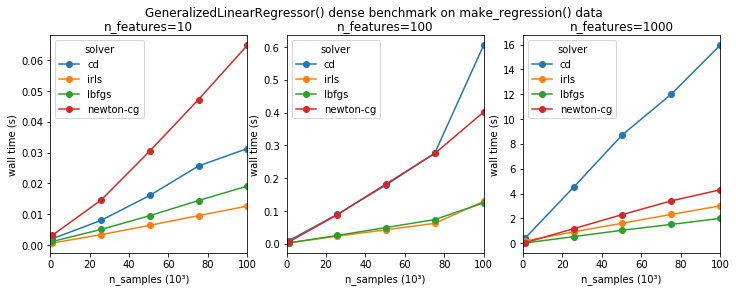

In [238]:
%%time

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {}

make_solver_benchmark(n_features=10, ax=ax[0])
make_solver_benchmark(n_features=100, ax=ax[1])
make_solver_benchmark(n_features=1000, ax=ax[2])

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(GeneralizedLinearRegressor(**kwargs))
        + " dense benchmark on make_regression() data"
    )

### 1.1.2 Memory usage

CPU times: user 5min 49s, sys: 20.1 s, total: 6min 9s
Wall time: 1min 40s


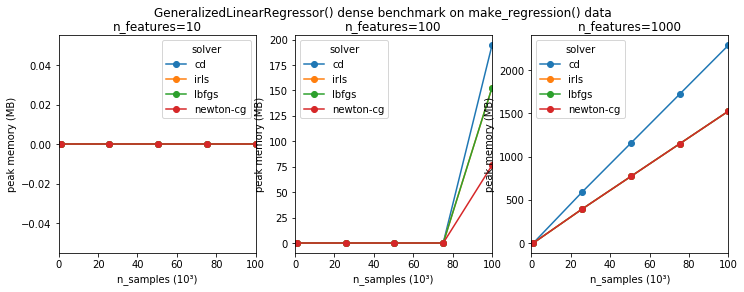

In [246]:
%%time

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {"metric_name": "peak_memory"}

make_solver_benchmark(n_features=10, ax=ax[0], **kwargs)
make_solver_benchmark(n_features=100, ax=ax[1], **kwargs)
make_solver_benchmark(n_features=1000, ax=ax[2], **kwargs)

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(GeneralizedLinearRegressor())
        + " dense benchmark on make_regression() data"
    )

### 1.2. Dense n_samples<n_features, alpha=1, family="normal", link="identity"

/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)


/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)


/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/src/scikit-learn/sklearn/linear_model/_glm.py:1388: ConvergenceWarning: Coordinate descent failed to converge. Increase the maximum number of iterations max_iter (currently 100)
  " (currently {0})".format(max_iter), ConvergenceWarning)
/home/rth/sr

CPU times: user 18min 17s, sys: 48.2 s, total: 19min 5s
Wall time: 4min 46s


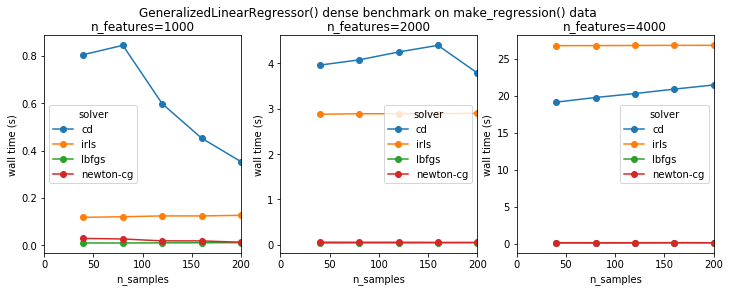

In [61]:
%%time

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {}

n_samples_range = np.linspace(40, 200, 5, dtype=np.int)

make_solver_benchmark(n_features=1000, n_samples_range=n_samples_range, ax=ax[0])
make_solver_benchmark(n_features=2000, n_samples_range=n_samples_range, ax=ax[1])
make_solver_benchmark(n_features=4000, n_samples_range=n_samples_range, ax=ax[2])

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(GeneralizedLinearRegressor(**kwargs))
        + " on make_regression() data"
    )

### 1.3. Dense, n_samples>>n_features, family="poisson", link="log"

The target doesn't follow the appropriate distribution, this merely intends to compare run time. The results are fairly similar to the case family="normal", link="identity"

CPU times: user 4min 45s, sys: 12.9 s, total: 4min 58s
Wall time: 1min 21s


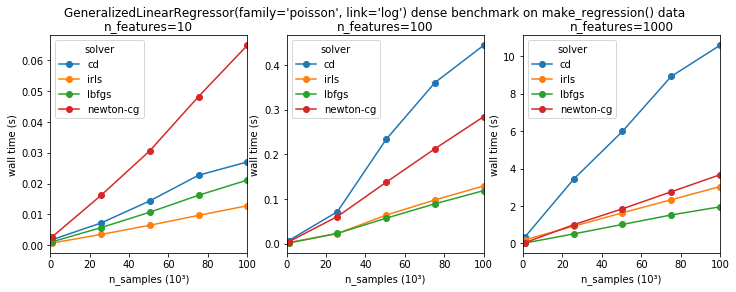

In [53]:
%%time

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {"family": "poisson", "link": "log"}

make_regression_benchmark(n_features=10, ax=ax[0])
make_regression_benchmark(n_features=100, ax=ax[1])
make_regression_benchmark(n_features=1000, ax=ax[2])

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(GeneralizedLinearRegressor(**kwargs))
        + " on make_regression() data"
    )

### 1.4. Dense, n_samples>>n_features, family="binomial" (i.e. LogisticRegression)

CPU times: user 4min 6s, sys: 11.1 s, total: 4min 17s
Wall time: 1min 9s


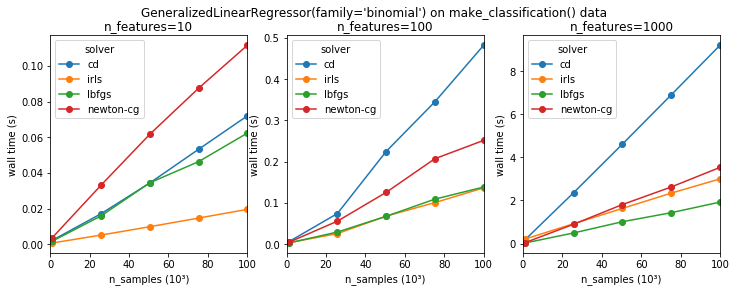

In [178]:
%%time

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = dict(family="binomial", task="classification")

make_solver_benchmark(n_features=10, ax=ax[0], **kwargs)
make_solver_benchmark(n_features=100, ax=ax[1], **kwargs)
make_solver_benchmark(n_features=1000, ax=ax[2], **kwargs)

glm_kwargs = {key: val for key, val in kwargs.items()
              if key not in ['task', 'repeat']}

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(GeneralizedLinearRegressor(**glm_kwargs))
        + " on make_classification() data"
    )

### 1.5. Sparse, n_samples>>n_features, family="normal"

#### 1.5.1 Run time

CPU times: user 6min 14s, sys: 1min 31s, total: 7min 46s
Wall time: 6min 44s


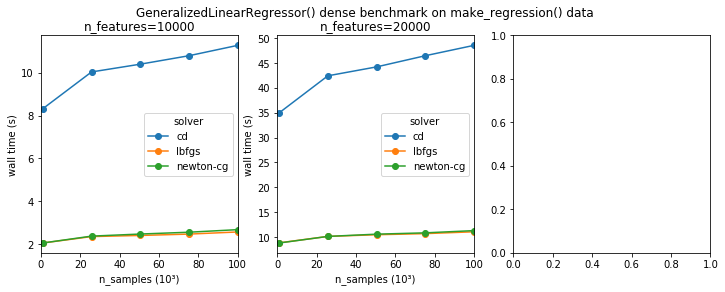

In [210]:
%%time

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = dict(sparse=True)

make_solver_benchmark(n_features=10000, ax=ax[0], **kwargs)
make_solver_benchmark(n_features=20000, ax=ax[1], **kwargs)
#make_solver_benchmark(n_features=47000, ax=ax[2], **kwargs)

glm_kwargs = {key: val for key, val in kwargs.items()
              if key not in ['task', 'repeat', 'sparse']}

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(GeneralizedLinearRegressor(**glm_kwargs))
        + " dense benchmark on make_regression() data"
    )

#### 1.5.1 Memory usage

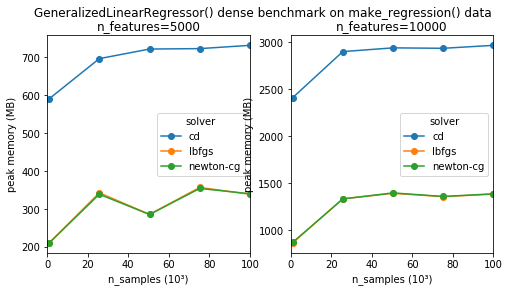

In [245]:
#%%time

# Note: this takes a while

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

kwargs = dict(sparse=True, metric_name="peak_memory")

make_solver_benchmark(n_features=5000, ax=ax[0], **kwargs)
make_solver_benchmark(n_features=10000, ax=ax[1], **kwargs)

glm_kwargs = {
    key: val
    for key, val in kwargs.items()
    if key not in ["task", "repeat", "sparse", "metric_name"]
}

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(GeneralizedLinearRegressor(**glm_kwargs))
        + " dense benchmark on make_regression() data"
    )

## 2. Comparison with existing scikit-learn models

In [12]:
from matplotlib.ticker import EngFormatter
from sklearn.metrics import mean_absolute_error, accuracy_score


def bench_estimators_relative(
    estimator,
    estimator_ref,
    n_features_range=np.array([2, 10, 50, 200, 1000]),
    n_samples_range=np.array([1000, 4000, 10_000, 40_000, 100_000, 400_000]),
    str_repr=True,
    repeat=1,
    task="regression",
    sparse=False,
    metric="wall_time",
):

    n_features_range = n_features_range.round().astype(np.int)
    n_samples_range = n_samples_range.round().astype(np.int)

    dataset_kwargs = dict(
        n_samples=n_samples_range.max(),
        n_features=n_features_range.max(),
        n_informative=n_features_range.max() // 5,
    )
    if task == "regression":
        if sparse:
            rcv1 = fetch_rcv1()
            _, y = make_regression(n_samples=n_samples_range.max(), random_state=42)
            if (
                rcv1.data.shape[0] < n_samples_range.max()
                or rcv1.data.shape[1] < n_features
            ):
                raise ValueError
            X = rcv1.data
        else:
            X, y = make_regression(
                effective_rank=n_features_range.max() // 5,
                tail_strength=0.6,
                **dataset_kwargs,
            )
    elif task == "classification":
        X, y = make_classification(n_classes=2, **dataset_kwargs)
    else:
        raise ValueError

    X = StandardScaler().fit_transform(X)

    bench = []
    if metric == "intercept_coef_err":
        from tqdm.auto import tqdm

        n_samples_range_iter = tqdm(n_samples_range, leave=False)
    else:
        n_samples_range_iter = n_samples_range

    for n_samples in n_samples_range_iter:
        for n_features in n_features_range:
            if metric == "intercept_coef_err":
                estimator_ref.fit(X[:n_samples, :n_features], y[:n_samples])
                estimator.fit(X[:n_samples, :n_features], y[:n_samples])
                intercept_err = np.mean(
                    np.abs(
                        (estimator.intercept_ - estimator_ref.intercept_)
                        / estimator_ref.intercept_
                    )
                )
                mask = estimator_ref.coef_ >= 1e-9
                coef_err = np.mean(
                    np.abs(
                        (estimator.coef_ - estimator_ref.coef_)[mask]
                        / estimator_ref.coef_[mask]
                    )
                )

                bench.append(
                    {
                        "n_samples": n_samples,
                        "n_features": n_features,
                        "err": f"{intercept_err:.1e} | {coef_err:.1e}",
                    }
                )
            elif metric == "train_test_err":
                X_train, X_test, y_train, y_test = train_test_split(
                    X[:n_samples, :n_features], y[:n_samples], random_state=42
                )
                estimator_ref.fit(X_train, y_train)
                estimator.fit(X_test, y_test)
                if task == "regression":
                    evaluation_score = mean_absolute_error
                elif task == "classification":
                    evaluation_score = accuracy_score
                else:
                    raise ValueError

                train_score_ref = mean_absolute_error(
                    y_train, estimator_ref.predict(X_train)
                )
                train_score = mean_absolute_error(y_train, estimator.predict(X_train))
                test_score_ref = mean_absolute_error(
                    y_test, estimator_ref.predict(X_test)
                )
                test_score = mean_absolute_error(y_test, estimator.predict(X_test))

                bench.append(
                    {
                        "n_samples": n_samples,
                        "n_features": n_features,
                        "err": f"ref: {train_score_ref:.3f} | {test_score_ref:.3f} - "
                        f"GLM: {train_score:.3f} | {test_score_ref:.3f}",
                    }
                )

            else:
                for model in [estimator, estimator_ref]:
                    with sklearn.config_context(print_changed_only=True):
                        tags = {
                            "n_samples": n_samples,
                            "n_features": n_features,
                            "model": str(model),
                        }
                    bench.append(
                        delayed(model, tags=tags).fit(
                            X[:n_samples, :n_features], y[:n_samples]
                        )
                    )
    if metric in ["intercept_coef_err", "train_test_err"]:
        return (
            pd.DataFrame(bench).set_index(["n_samples", "n_features"]).err.unstack(-1)
        )
    else:
        if repeat > 1:
            res = timeit(bench, repeat=3).loc[:, ("wall_time", "mean")].unstack(-1)
        else:
            res = timeit(bench).wall_time.unstack(-1)
        ratio = (res.iloc[:, 1] / res.iloc[:, 0]).unstack(-1).round(1)
        ref_t = res.iloc[:, 1].unstack(-1)
        if str_repr:
            fmt = EngFormatter(unit="s", places=0)
            return (
                "x" + ratio.astype(str) + " (" + ref_t.applymap(fmt.format_data) + ")"
            )
        return ratio, ref_t

### 2.1 Comparison with Ridge, dense, default solver

The below table includes
 - The speed factor (`xN`): i.e. how many times the GLM regressor is faster than Ridge.In this case it's always slower. Default solvers are used: "irls" for GLM and "cholesky" for `Ridge`. 
 - Baseline run time: the run time for the reference estimator (here `Ridge`).

In [151]:
%%time

from sklearn.linear_model import Ridge

res = bench_estimators_relative(
    GeneralizedLinearRegressor(), estimator_ref=Ridge(), repeat=3
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,x0.6 (350 µs),x0.6 (385 µs),x0.4 (539 µs),x0.2 (1 ms),x0.1 (19 ms)
4000,x0.5 (498 µs),x0.6 (602 µs),x0.5 (1 ms),x0.4 (6 ms),x0.2 (45 ms)
10000,x0.5 (802 µs),x0.6 (1 ms),x0.7 (4 ms),x0.5 (14 ms),x0.2 (101 ms)
40000,x0.5 (3 ms),x0.7 (5 ms),x0.7 (14 ms),x0.5 (68 ms),x0.3 (370 ms)
100000,x0.7 (10 ms),x0.8 (14 ms),x0.5 (36 ms),x0.5 (168 ms),x0.3 (908 ms)
400000,x0.7 (41 ms),x0.6 (60 ms),x0.6 (182 ms),x0.5 (649 ms),x0.3 (4 s)


CPU times: user 9min 51s, sys: 28.6 s, total: 10min 20s
Wall time: 3min 7s


We can also look at the relative error for `intercept_` | `coef_` between the the reference and the GLM implementation

In [265]:
from sklearn.linear_model import Ridge

res = bench_estimators_relative(
    GeneralizedLinearRegressor(), estimator_ref=Ridge(),
    metric="intercept_coef_err"
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,4.9e-01 | 5.0e-01,6.6e-01 | 4.1e+00,5.4e-02 | 6.9e-01,3.5e-01 | 8.3e-01,1.8e+00 | 9.4e+00
4000,6.5e-02 | 5.2e-01,2.9e-01 | 5.3e-01,5.1e-01 | 5.1e-01,5.7e-01 | 7.2e-01,4.2e-01 | 1.3e+03
10000,1.1e-02 | 5.3e-01,4.6e-02 | 5.3e-01,4.5e-02 | 6.3e-01,3.8e-02 | 7.3e-01,1.3e+00 | 2.3e+03
40000,1.7e-01 | 5.1e-01,7.6e-02 | 5.4e-01,4.2e+01 | 7.9e-01,7.4e-01 | 7.2e-01,5.1e-01 | 6.0e+04
100000,2.0e-02 | 5.1e-01,3.2e-02 | 6.3e-01,1.4e-01 | 5.2e-01,1.9e-01 | 5.7e-01,4.6e-01 | 3.4e+04
400000,4.2e-15 | 5.1e-01,9.0e-15 | 6.1e-01,1.2e-14 | 5.9e-01,3.7e-14 | 7.2e-01,6.9e-15 | 1.3e+05


New let's look at the Mean Average Error (MAE) for the reference implementation and the GLM implementation. The table below includes train and test MAE in both cases,

In [8]:
from sklearn.linear_model import Ridge

res = bench_estimators_relative(
    GeneralizedLinearRegressor(), estimator_ref=Ridge(),
    metric="train_test_err"
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,ref: 0.609 | 0.576 - GLM: 0.623 | 0.576,ref: 0.597 | 0.573 - GLM: 0.617 | 0.573,ref: 0.576 | 0.541 - GLM: 0.607 | 0.541,ref: 0.461 | 0.574 - GLM: 0.590 | 0.574,ref: 0.001 | 0.253 - GLM: 0.510 | 0.253
4000,ref: 0.600 | 0.588 - GLM: 0.600 | 0.588,ref: 0.594 | 0.585 - GLM: 0.599 | 0.585,ref: 0.576 | 0.579 - GLM: 0.592 | 0.579,ref: 0.506 | 0.538 - GLM: 0.558 | 0.538,ref: 0.000 | 0.000 - GLM: 0.369 | 0.000
10000,ref: 0.588 | 0.594 - GLM: 0.589 | 0.594,ref: 0.584 | 0.591 - GLM: 0.586 | 0.591,ref: 0.570 | 0.579 - GLM: 0.577 | 0.579,ref: 0.503 | 0.521 - GLM: 0.537 | 0.521,ref: 0.000 | 0.000 - GLM: 0.309 | 0.000
40000,ref: 0.586 | 0.586 - GLM: 0.586 | 0.586,ref: 0.584 | 0.583 - GLM: 0.584 | 0.583,ref: 0.572 | 0.572 - GLM: 0.576 | 0.572,ref: 0.509 | 0.515 - GLM: 0.531 | 0.515,ref: 0.000 | 0.000 - GLM: 0.287 | 0.000
100000,ref: 0.586 | 0.589 - GLM: 0.587 | 0.589,ref: 0.584 | 0.587 - GLM: 0.585 | 0.587,ref: 0.572 | 0.574 - GLM: 0.576 | 0.574,ref: 0.510 | 0.513 - GLM: 0.530 | 0.513,ref: 0.000 | 0.000 - GLM: 0.284 | 0.000
400000,ref: 0.585 | 0.584 - GLM: 0.585 | 0.584,ref: 0.583 | 0.581 - GLM: 0.583 | 0.581,ref: 0.570 | 0.570 - GLM: 0.574 | 0.570,ref: 0.508 | 0.508 - GLM: 0.528 | 0.508,ref: 0.000 | 0.000 - GLM: 0.282 | 0.000


### 2.2 Comparison with ElasticNet, L1+L2 penalty, cd solver

#### 2.2.1 Dense

The below table includes
 - The speed factor (`xN`): i.e. how many times the GLM regressor is faster than ElasticNet. In this case it's appears to be faster (need to double-check).
 - Baseline run time: the run time for the reference estimator (here `ElasticNet`).

In [152]:
%%time

from sklearn.linear_model import ElasticNet

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="cd", l1_ratio=0.5, start_params='zero'),
    estimator_ref=ElasticNet(max_iter=100, l1_ratio=0.5),
    repeat=3
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,x5.0 (1 ms),x5.0 (1 ms),x4.3 (2 ms),x4.5 (4 ms),x6.6 (41 ms)
4000,x5.3 (1 ms),x3.6 (2 ms),x2.2 (3 ms),x2.0 (13 ms),x4.7 (167 ms)
10000,x5.4 (2 ms),x3.1 (3 ms),x1.7 (7 ms),x2.1 (37 ms),x3.8 (424 ms)
40000,x4.5 (4 ms),x1.7 (7 ms),x1.4 (27 ms),x2.1 (185 ms),x3.2 (1 s)
100000,x5.1 (15 ms),x2.2 (27 ms),x2.2 (159 ms),x2.3 (642 ms),x3.2 (4 s)
400000,x4.7 (61 ms),x2.2 (133 ms),x1.8 (614 ms),x2.0 (3 s),x2.8 (18 s)


CPU times: user 10min 21s, sys: 35.7 s, total: 10min 56s
Wall time: 3min 47s


Evaluating the impact of the `start_params` parameters.

In [153]:
%%time

from sklearn.linear_model import ElasticNet

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="cd", l1_ratio=0.5, start_params='guess'),
    estimator_ref=ElasticNet(max_iter=100, l1_ratio=0.5),
    repeat=3                 
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,x3.4 (758 µs),x3.6 (918 µs),x3.9 (2 ms),x5.5 (6 ms),x9.3 (57 ms)
4000,x3.7 (1 ms),x2.7 (1 ms),x2.1 (3 ms),x2.4 (16 ms),x5.7 (200 ms)
10000,x4.2 (2 ms),x2.5 (2 ms),x1.8 (7 ms),x2.2 (38 ms),x4.6 (513 ms)
40000,x6.2 (6 ms),x2.2 (9 ms),x1.7 (33 ms),x2.4 (234 ms),x4.3 (2 s)
100000,x4.5 (13 ms),x1.9 (23 ms),x2.2 (156 ms),x2.3 (657 ms),x3.8 (5 s)
400000,x4.1 (53 ms),x1.8 (110 ms),x1.8 (589 ms),x2.0 (3 s),x3.3 (21 s)


CPU times: user 11min 13s, sys: 38.5 s, total: 11min 52s
Wall time: 4min 1s


Relative error for `intercept_` | `coef_`

In [270]:
from sklearn.linear_model import ElasticNet

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="cd", l1_ratio=0.5, start_params='guess'),
    estimator_ref=ElasticNet(max_iter=100, l1_ratio=0.5),
    metric="intercept_coef_err"                
)
display(res)

/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars

/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rth/miniconda3/envs/sklearn-env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars

n_features,2,10,50,200,1000
n_samples,,,,,
1000,0.0e+00 | nan,0.0e+00 | nan,0.0e+00 | nan,0.0e+00 | nan,0.0e+00 | nan
4000,3.6e-16 | nan,3.6e-16 | nan,3.6e-16 | nan,3.6e-16 | nan,3.6e-16 | nan
10000,3.7e-15 | nan,3.7e-15 | nan,3.7e-15 | nan,3.7e-15 | nan,3.7e-15 | nan
40000,3.2e-15 | nan,3.2e-15 | nan,3.2e-15 | nan,3.2e-15 | nan,3.2e-15 | nan
100000,3.6e-14 | nan,3.6e-14 | nan,3.6e-14 | nan,3.6e-14 | nan,3.6e-14 | nan
400000,1.8e-15 | nan,1.8e-15 | nan,1.8e-15 | nan,1.8e-15 | nan,1.8e-15 | nan


CPU times: user 4min 24s, sys: 17.8 s, total: 4min 42s
Wall time: 1min 47s


MAE for the reference implementation and the GLM implementation on the train | test datasets

In [9]:
from sklearn.linear_model import ElasticNet

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="cd", l1_ratio=0.5, start_params='guess'),
    estimator_ref=ElasticNet(max_iter=100, l1_ratio=0.5),
    metric="train_test_err"                
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,ref: 0.598 | 0.612 - GLM: 0.601 | 0.612,ref: 0.598 | 0.612 - GLM: 0.601 | 0.612,ref: 0.598 | 0.612 - GLM: 0.601 | 0.612,ref: 0.598 | 0.612 - GLM: 0.601 | 0.612,ref: 0.598 | 0.612 - GLM: 0.601 | 0.612
4000,ref: 0.604 | 0.625 - GLM: 0.604 | 0.625,ref: 0.604 | 0.625 - GLM: 0.604 | 0.625,ref: 0.604 | 0.625 - GLM: 0.604 | 0.625,ref: 0.604 | 0.625 - GLM: 0.604 | 0.625,ref: 0.604 | 0.625 - GLM: 0.604 | 0.625
10000,ref: 0.601 | 0.618 - GLM: 0.601 | 0.618,ref: 0.601 | 0.618 - GLM: 0.601 | 0.618,ref: 0.601 | 0.618 - GLM: 0.601 | 0.618,ref: 0.601 | 0.618 - GLM: 0.601 | 0.618,ref: 0.601 | 0.618 - GLM: 0.601 | 0.618
40000,ref: 0.607 | 0.608 - GLM: 0.607 | 0.608,ref: 0.607 | 0.608 - GLM: 0.607 | 0.608,ref: 0.607 | 0.608 - GLM: 0.607 | 0.608,ref: 0.607 | 0.608 - GLM: 0.607 | 0.608,ref: 0.607 | 0.608 - GLM: 0.607 | 0.608
100000,ref: 0.606 | 0.607 - GLM: 0.606 | 0.607,ref: 0.606 | 0.607 - GLM: 0.606 | 0.607,ref: 0.606 | 0.607 - GLM: 0.606 | 0.607,ref: 0.606 | 0.607 - GLM: 0.606 | 0.607,ref: 0.606 | 0.607 - GLM: 0.606 | 0.607
400000,ref: 0.609 | 0.610 - GLM: 0.609 | 0.610,ref: 0.609 | 0.610 - GLM: 0.609 | 0.610,ref: 0.609 | 0.610 - GLM: 0.609 | 0.610,ref: 0.609 | 0.610 - GLM: 0.609 | 0.610,ref: 0.609 | 0.610 - GLM: 0.609 | 0.610


### 2.3 Comparison with LogisticRegression, binary classification

#### 2.3.1 lbfgs-lbfgs solver, dense

In [168]:
%%time

from sklearn.linear_model import LogisticRegression

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="lbfgs", family="binomial"),
    estimator_ref=LogisticRegression(solver="lbfgs", max_iter=100),
    repeat=1,
    task="classification"
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,x0.8 (1 ms),x0.8 (1 ms),x0.9 (2 ms),x0.9 (3 ms),x1.0 (23 ms)
4000,x0.7 (2 ms),x0.7 (2 ms),x0.8 (3 ms),x0.7 (7 ms),x1.2 (109 ms)
10000,x0.6 (4 ms),x0.7 (5 ms),x0.7 (6 ms),x0.7 (18 ms),x0.7 (143 ms)
40000,x0.7 (14 ms),x0.7 (17 ms),x0.8 (26 ms),x0.7 (86 ms),x0.6 (476 ms)
100000,x0.7 (35 ms),x0.6 (41 ms),x0.7 (77 ms),x0.6 (215 ms),x0.5 (1 s)
400000,x1.1 (143 ms),x0.9 (164 ms),x0.9 (308 ms),x0.8 (842 ms),x0.6 (4 s)


CPU times: user 2min 48s, sys: 11.2 s, total: 3min
Wall time: 1min 2s


Relative error for `intercept_` | `coef_`

In [275]:
from sklearn.linear_model import LogisticRegression

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="lbfgs", family="binomial"),
    estimator_ref=LogisticRegression(solver="lbfgs", max_iter=100),
    repeat=1,
    task="classification",
    metric="intercept_coef_err"
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,7.5e-03 | 7.9e-01,3.1e-02 | 8.0e-01,2.9e-01 | 8.8e-01,6.1e-01 | 9.8e-01,6.9e-01 | 1.0e+00
4000,6.5e-02 | 8.0e-01,1.0e-01 | 7.9e-01,1.2e+00 | 7.9e-01,8.3e-01 | 8.2e-01,9.5e-01 | 9.9e-01
10000,4.9e-03 | 8.0e-01,1.2e-01 | 8.0e-01,1.8e-01 | 9.7e-01,1.6e+00 | 8.2e-01,1.5e+00 | 1.3e+00
40000,2.1e-03 | 8.0e-01,3.2e-02 | 7.9e-01,2.6e-01 | 8.1e-01,1.0e+03 | 9.3e-01,1.7e+00 | 1.0e+00
100000,2.1e-02 | 8.1e-01,6.0e-03 | 8.0e-01,1.1e-01 | 8.1e-01,1.3e+00 | 1.0e+00,3.6e+00 | 1.4e+00
400000,4.8e-06 | 8.0e-01,5.7e-04 | 8.0e-01,2.4e-01 | 8.4e-01,1.1e+00 | 1.1e+00,1.0e+00 | 1.2e+00


accuracy for the reference implementation and the GLM implementation on the train | test datasets

In [13]:
from sklearn.linear_model import LogisticRegression

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="lbfgs", family="binomial"),
    estimator_ref=LogisticRegression(solver="lbfgs", max_iter=100),
    repeat=1,
    task="classification",
    metric="train_test_err"
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,ref: 0.475 | 0.508 - GLM: 0.500 | 0.508,ref: 0.457 | 0.492 - GLM: 0.501 | 0.492,ref: 0.355 | 0.416 - GLM: 0.493 | 0.416,ref: 0.208 | 0.428 - GLM: 0.486 | 0.428,ref: 0.000 | 0.308 - GLM: 0.453 | 0.308
4000,ref: 0.488 | 0.502 - GLM: 0.500 | 0.502,ref: 0.467 | 0.501 - GLM: 0.500 | 0.501,ref: 0.386 | 0.421 - GLM: 0.495 | 0.421,ref: 0.309 | 0.377 - GLM: 0.486 | 0.377,ref: 0.003 | 0.287 - GLM: 0.448 | 0.287
10000,ref: 0.500 | 0.494 - GLM: 0.500 | 0.494,ref: 0.491 | 0.494 - GLM: 0.500 | 0.494,ref: 0.389 | 0.408 - GLM: 0.493 | 0.408,ref: 0.325 | 0.351 - GLM: 0.484 | 0.351,ref: 0.117 | 0.192 - GLM: 0.442 | 0.192
40000,ref: 0.497 | 0.510 - GLM: 0.500 | 0.510,ref: 0.495 | 0.508 - GLM: 0.500 | 0.508,ref: 0.393 | 0.401 - GLM: 0.493 | 0.401,ref: 0.335 | 0.343 - GLM: 0.484 | 0.343,ref: 0.148 | 0.169 - GLM: 0.439 | 0.169
100000,ref: 0.498 | 0.503 - GLM: 0.500 | 0.503,ref: 0.496 | 0.505 - GLM: 0.500 | 0.505,ref: 0.396 | 0.395 - GLM: 0.493 | 0.395,ref: 0.341 | 0.341 - GLM: 0.484 | 0.341,ref: 0.155 | 0.162 - GLM: 0.439 | 0.162
400000,ref: 0.499 | 0.503 - GLM: 0.500 | 0.503,ref: 0.498 | 0.501 - GLM: 0.500 | 0.501,ref: 0.396 | 0.394 - GLM: 0.493 | 0.394,ref: 0.340 | 0.340 - GLM: 0.484 | 0.340,ref: 0.156 | 0.161 - GLM: 0.438 | 0.161


#### 2.3.2 irls-lbfgs solver, dense

In [181]:
from sklearn.linear_model import LogisticRegression

res = bench_estimators_relative(
    GeneralizedLinearRegressor(solver="irls", family="binomial"),
    estimator_ref=LogisticRegression(solver="lbfgs", max_iter=100),
    repeat=3,
    task="classification"
)
display(res)

n_features,2,10,50,200,1000
n_samples,,,,,
1000,x1.6 (1 ms),x1.9 (1 ms),x1.1 (2 ms),x0.4 (3 ms),x0.1 (25 ms)
4000,x1.8 (2 ms),x1.8 (2 ms),x1.1 (3 ms),x0.4 (6 ms),x0.3 (99 ms)
10000,x1.9 (4 ms),x1.7 (5 ms),x1.0 (6 ms),x0.6 (17 ms),x0.3 (138 ms)
40000,x1.7 (15 ms),x1.6 (17 ms),x1.1 (26 ms),x0.6 (80 ms),x0.4 (476 ms)
100000,x1.7 (35 ms),x1.6 (42 ms),x0.9 (77 ms),x0.6 (198 ms),x0.4 (1 s)
400000,x1.7 (141 ms),x1.3 (165 ms),x0.9 (307 ms),x0.6 (775 ms),x0.4 (5 s)


`GeneralizedLinearRegressor(solver="irls", family="binomial")` is faster than `LogisticRegression(solver="lbfgs")` when n_features ≲ 20.